In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

class Food101Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def create_food101_dataloaders(data_dir, batch_size=32, train_split=0.9, num_workers=0):
    """
    Create train and validation dataloaders for Food-101 dataset.
    
    Args:
        data_dir: Path to food-101 directory containing class folders
        batch_size: Batch size for dataloaders
        train_split: Proportion of data to use for training (default: 0.9)
        num_workers: Number of workers for data loading (default: 0 for Windows compatibility)
    
    Returns:
        train_loader, val_loader, class_names
    """
    
    print("Scanning directory structure...")
    
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Collect all image paths and labels (only file paths, not loading images)
    image_paths = []
    labels = []
    class_names = sorted([d for d in os.listdir(data_dir) 
                         if os.path.isdir(os.path.join(data_dir, d))])
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    print(f"Found {len(class_names)} classes")
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        class_images = [os.path.join(class_dir, img) 
                       for img in os.listdir(class_dir)
                       if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        image_paths.extend(class_images)
        labels.extend([class_to_idx[class_name]] * len(class_images))
        
        print(f"  {class_name}: {len(class_images)} images")
    
    print(f"\nTotal images found: {len(image_paths)}")
    print("Splitting dataset...")
    
    # Split into train and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, 
        train_size=train_split, 
        stratify=labels,
        random_state=42
    )
    
    print(f"Training images: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")
    
    # Create datasets
    train_dataset = Food101Dataset(train_paths, train_labels, transform=train_transform)
    val_dataset = Food101Dataset(val_paths, val_labels, transform=val_transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print("\nDataLoaders created successfully!")
    print(f"Classes: {class_names}\n")
    
    return train_loader, val_loader, class_names

# Direct execution code
print("Starting Food-101 DataLoader creation...\n")
data_directory = "D:\Datasets\\food-101"

# Create dataloaders
train_loader, val_loader, classes = create_food101_dataloaders(
    data_dir=data_directory,
    batch_size=32,
    train_split=0.9,
    num_workers=0  # Set to 0 for Windows, can increase on Linux/Mac
)

# Test the dataloaders
print("--- Testing DataLoaders ---")
print("Loading first batch (this may take a moment)...")
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image min/max: {images.min():.3f} / {images.max():.3f}")
    print(f"First batch labels: {labels[:5].tolist()}")
    break

print("\nDataLoader setup complete and tested!")

<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:121: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Kartik\AppData\Local\Temp\ipykernel_27120\3121116806.py:121: SyntaxWarning: invalid escape sequence '\D'
  data_directory = "D:\Datasets\\food-101"


Starting Food-101 DataLoader creation...

Scanning directory structure...
Found 10 classes
  caesar_salad: 1000 images
  chicken_curry: 1000 images
  donuts: 1000 images
  fried_rice: 1000 images
  hamburger: 1000 images
  ice_cream: 1000 images
  pancakes: 1000 images
  pizza: 1000 images
  ramen: 1000 images
  sushi: 1000 images

Total images found: 10000
Splitting dataset...
Training images: 9000
Validation images: 1000

DataLoaders created successfully!
Classes: ['caesar_salad', 'chicken_curry', 'donuts', 'fried_rice', 'hamburger', 'ice_cream', 'pancakes', 'pizza', 'ramen', 'sushi']

--- Testing DataLoaders ---
Loading first batch (this may take a moment)...
Batch shape: torch.Size([32, 3, 255, 255])
Labels shape: torch.Size([32])
Image min/max: -2.118 / 2.640
First batch labels: [9, 7, 4, 8, 3]

DataLoader setup complete and tested!


In [ ]:
## custom implementation of CNN 

import torch.nn as nn
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)      # [B, 128, H, W]
        x = self.gap(x)           # [B, 128, 1, 1]
        x = torch.flatten(x, 1)   # [B, 128]
        x = self.classifier(x)    # [B, num_classes]
        return x
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

custom_model = CustomCNN(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()          # categorical_crossentropy
optimizer = torch.optim.Adam(
    custom_model.parameters(), 
    lr=1e-3
)
# check if this works 
images, labels = next(iter(train_loader))
images = images.to(device)

outputs = custom_model(images)

print("Output shape:", outputs.shape)

Output shape: torch.Size([32, 10])


Using device: cpu

Epoch [1/2]
Train Loss: 2.3039 | Train Acc: 0.0000
Custom CNN Metrics
Accuracy : 0.0980
Precision: 0.0205
Recall   : 0.0980
F1-score : 0.0288


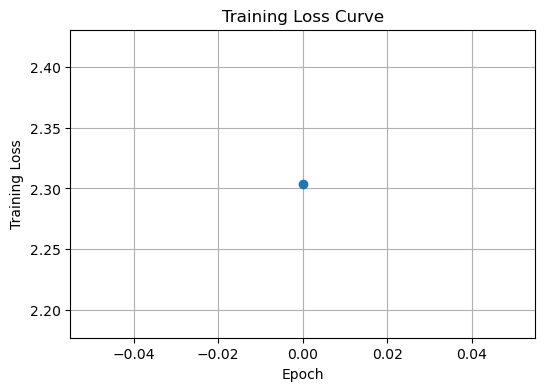

In [25]:
# training and validation

# ===============================
# Imports
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Custom CNN with Global Average Pooling
# ===============================
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ===============================
# Metric Evaluation Function
# ===============================
def evaluate_metrics(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return accuracy, precision, recall, f1

# ===============================
# Training Loop with Metrics
# ===============================
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=5
):
    
    train_losses = []


    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # -------- Training --------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # capture training losses 
        epoch_loss = running_loss / total
        train_losses.append(epoch_loss)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # -------- Validation Metrics --------
        custom_acc, custom_prec, custom_rec, custom_f1 = evaluate_metrics(
            model=custom_model,
            dataloader=val_loader,
            device=device
        )

        print("Custom CNN Metrics")
        print(f"Accuracy : {custom_acc:.4f}")
        print(f"Precision: {custom_prec:.4f}")
        print(f"Recall   : {custom_rec:.4f}")
        print(f"F1-score : {custom_f1:.4f}")

        return train_losses

# ===============================
# Model, Loss, Optimizer
# ===============================
num_classes = len(classes)   # classes from your DataLoader function

custom_model = CustomCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ===============================
# Train
# ===============================
num_epochs = 2   # start with 1–2 for debugging if needed

train_losses = train_model(
    custom_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=num_epochs
)

plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()



In [27]:
#training validation

print(images.shape)   # [B, 3, H, W]
print(outputs.shape)  # [B, num_classes]
print(labels.min(), labels.max())

torch.Size([32, 3, 255, 255])
torch.Size([32, 10])
tensor(0) tensor(9)


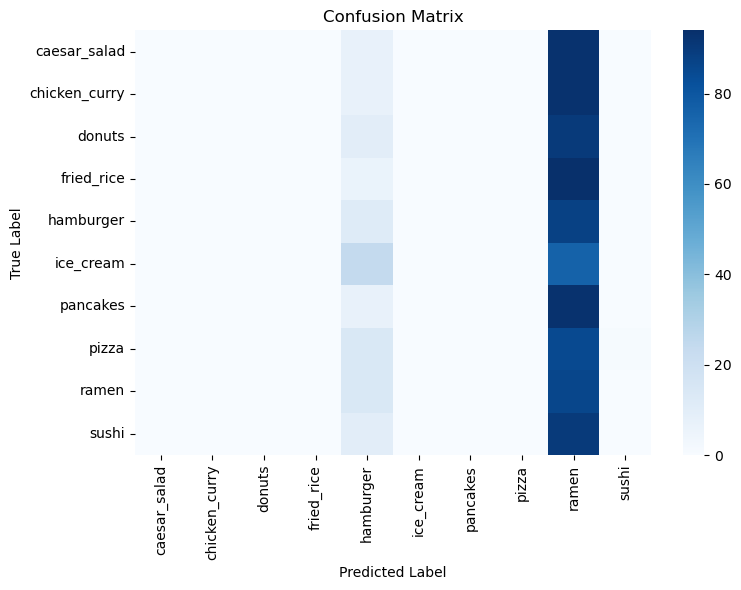

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plot confusion matrix 
def get_all_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_all_predictions(custom_model, val_loader, device)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    xticklabels=classes,
    yticklabels=classes,
    annot=False,
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

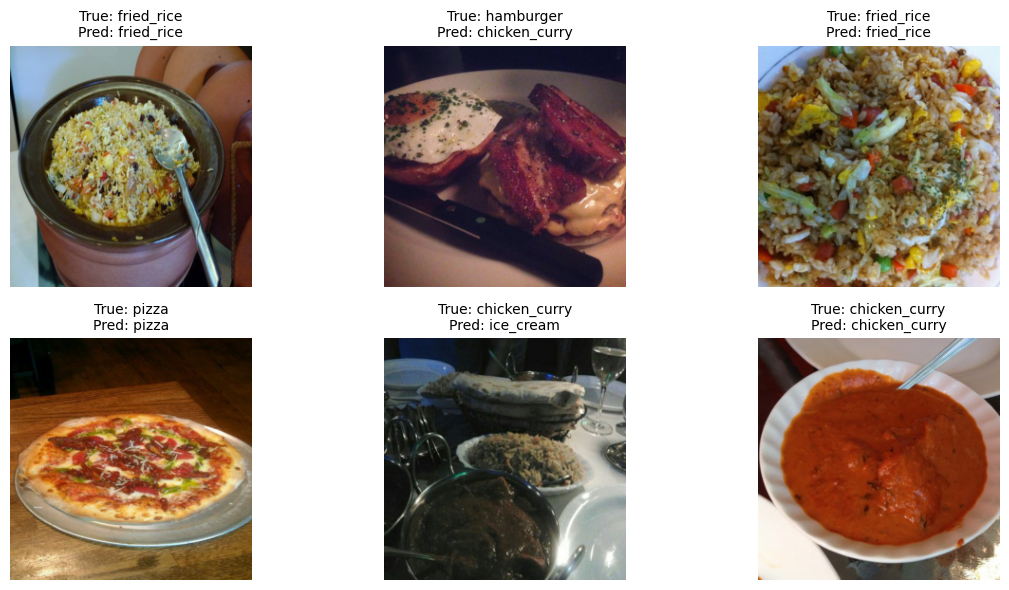

In [28]:
# show sample predictions 
import random

def show_sample_predictions(model, dataloader, classes, device, num_images=6):
    model.eval()

    images, labels = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        img = images[i].permute(1, 2, 0)

        # Unnormalize for display
        img = img * torch.tensor([0.229, 0.224, 0.225]) + \
              torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)

        plt.imshow(img)
        plt.title(
            f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}",
            fontsize=10
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_sample_predictions(
    model,
    val_loader,
    classes,
    device,
    num_images=6
)

In [29]:
# load pretrained model and modify architecture 

from torchvision import models

resnet_model = models.resnet18(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = False

num_classes = len(classes)

resnet_model.fc = torch.nn.Linear(
    resnet_model.fc.in_features,
    num_classes
)


resnet_model = resnet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    resnet_model.fc.parameters(),
    lr=1e-3
)

train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=1
)


resnet_acc, resnet_prec, resnet_rec, resnet_f1 = evaluate_metrics(
    model=resnet_model,
    dataloader=val_loader,
    device=device
)

print("ResNet-18 Metrics")
print(f"Accuracy : {resnet_acc:.4f}")
print(f"Precision: {resnet_prec:.4f}")
print(f"Recall   : {resnet_rec:.4f}")
print(f"F1-score : {resnet_f1:.4f}")

c:\Users\Kartik\anaconda3\envs\ai_ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kartik\anaconda3\envs\ai_ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/1]
Train Loss: 1.1651 | Train Acc: 0.0000
Custom CNN Metrics
Accuracy : 0.0980
Precision: 0.0205
Recall   : 0.0980
F1-score : 0.0288
ResNet-18 Metrics
Accuracy : 0.8050
Precision: 0.8113
Recall   : 0.8050
F1-score : 0.8025


In [30]:
# comparision of metrics 
custom_metrics = {
    "Accuracy": custom_acc,
    "Precision": custom_prec,
    "Recall": custom_rec,
    "F1": custom_f1
}

resnet_metrics = {
    "Accuracy": resnet_acc,
    "Precision": resnet_prec,
    "Recall": resnet_rec,
    "F1": resnet_f1
}

NameError: name 'custom_acc' is not defined